# Cats and Dogs project - classifing pictures without neural networks

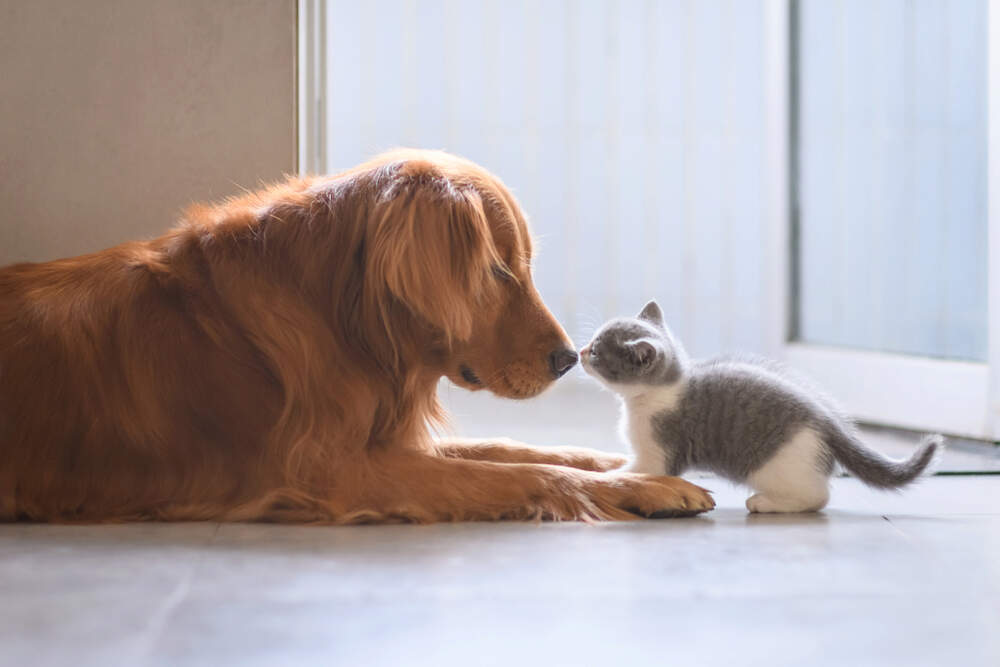

In this project we were asked to take the Cats and Dogs data set and to try to give the best prediction based on the models we learned in class, without using neural networks.

### Table of Contents:
    1. Getting to know the data, train test split, pca.
    2. Sampling models:
        a. knn classifier + grid search
        b. svc
        c. random forest classifier
        d. voting classifier
    3. comparing models scores and choosing the final model

## Getting to know the data, train test split, pca:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
plt.style.use('seaborn')

from matplotlib.image import imread
from PIL import Image
from os import listdir
from numpy import asarray

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Just before we started working on the data set, we wanted to have a look on the pictures in the data. we've noticed that the pictures are in different sizes. Thus, we resized them all to be at the same shape. Moreover, we converted all the photos to black so it'll have fewer dimentions.

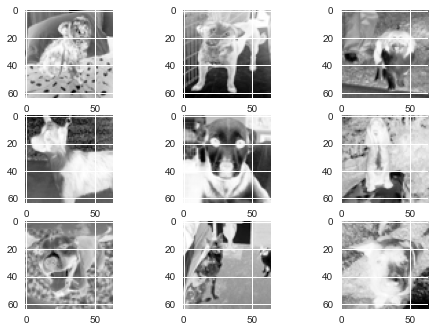

In [2]:
folder = 'C:\\אריאל\\שנה א\\סמסטר ב\\הדמיית נתונים\\Data_visualization_project\\Cats Vs Dogs\\train\\'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = Image.open(filename).resize((64, 64)).convert('L')
    pyplot.imshow(image)
display()

We loaded the pictures from the computer, then reshaped the pictures to be 2 dimentional, moved all the pixels to be in the range between 0 to 1 and splitted the data to train and test set.

In [3]:
folder = 'C:\\אריאל\\שנה א\\סמסטר ב\\הדמיית נתונים\\Data_visualization_project\\Cats Vs Dogs\\train\\'
photos, labels = list(), list()
count = 0
for image in listdir(folder):
    #print(count)
    output = 0
    if image.startswith('cat'):
        output = 1
    vec = asarray(Image.open(folder + image).resize((64, 64)).convert('L'))
    photos.append(vec)
    labels.append(output)
    count +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083


3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729


5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385


6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047


8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709


10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
1031

11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
1169

12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
1308

14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
1449

15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
1586

17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
1725

18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
1864

19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
2004

21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
2142

22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
22730
22731
22732
22733
22734
22735
22736
22737
22738
22739
22740
22741
22742
22743
22744
22745
22746
22747
22748
22749
22750
22751
22752
22753
22754
22755
22756
22757
22758
22759
22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772
22773
22774
22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785
22786
22787
22788
22789
22790
22791
2279

23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
2416

In [13]:
pictures = np.array(photos)

In [14]:
pictures = np.reshape(pictures, (25000, 64*64))
pictures = pictures/255

In [15]:
X_train, X_test, y_train, y_test = train_test_split(pictures, labels, test_size=0.1, random_state=42)

In [17]:
X_train.shape

(22500, 4096)

After making the intial transormation to the data, we wanted to reduce the number of dimention in each picture. Thus, we used PCA.

In [8]:
pca = PCA(n_components=0.95)
train = pca.fit_transform(X_train)

In [9]:
train.shape

(22500, 414)

As we can see, the number of the pixels in each photo dropped to 414! By preserving only 95% of the variance, the number of features dropped to about ten precent of the original number of features.

## Sampling models:
### a. knn classifier + grid search
Knn is a model that searches by given parameters the closest n neighbors of an item

Text(0, 0.5, 'Testing Accuracy')

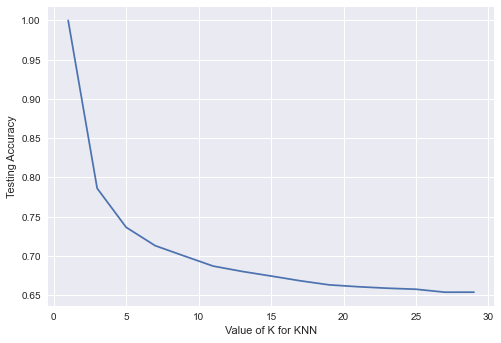

In [10]:
k_range = list(range(1, 31, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train, y_train)
    pred = knn.predict(train)
    scores.append(metrics.accuracy_score(y_train, pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

We can see that at about the difference between k=15 to k=30 is not that big, and thus we'll check only 'till this number.

In [11]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

k_range = list(range(1, 17, 2))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

In [12]:
Ks['k_mean'].sort_values(ascending=False)

15    0.593867
13    0.592933
11    0.588044
9     0.587511
7     0.582089
5     0.579022
3     0.568489
1     0.554089
Name: k_mean, dtype: float64

In [13]:
Ks['k_std'].sort_values(ascending=True)

7     0.008265
15    0.008835
9     0.008892
13    0.009204
5     0.009588
11    0.009927
1     0.010946
3     0.011003
Name: k_std, dtype: float64

It seems that the best k to choose is k=15 (best score, and second smallest std). we'll verify that using grid search.

In [14]:
knn=KNeighborsClassifier()
k_range = list(range(3,17,2))
print(k_range)
weight_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metrics_options)
grid=GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
print("getting to fit")
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

[3, 5, 7, 9, 11, 13, 15]
getting to fit
0.607777777777778
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [15]:
X_traina, X_trainb, y_traina, y_trainb = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### b. SVC

SVC is the classifier of SVM (support vector machine). It is based on logistic regression, but finds the line that keeps the biggest distance from each one of the labels.

In [16]:
svc = SVC()
svc.fit(X_traina, y_traina)
svc.score(X_trainb, y_trainb)
#scoresvc = cross_val_score(svc, X_train, y_train, cv=kf, scoring='accuracy')
#print(scoresvc.mean())
#print(scoresvc.std())

0.6791111111111111

### c. Random Forest Classifier

Random forest classifier is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_traina, y_traina)
rfc.score(X_trainb, y_trainb)
#scoresrfc = cross_val_score(rfc, X_train, y_train, cv=kf, scoring='accuracy')
#print(scoresrfc.mean())
#print(scoresrfc.std())

0.6564444444444445

### d. Voting Classifier

The Voting Classifier model is using other model and makes a vote between them. In it's base, the labek that most of the models voted to is the label that the Voting Classifier will return.

In [18]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan')
svca = SVC(probability=True)
voting_clf = VotingClassifier(
    estimators=[('knn', knn), ('svc', svca), ('rfc', rfc)],
    voting='soft')
voting_clf.fit(X_traina, y_traina)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=13)),
                             ('svc', SVC(probability=True)),
                             ('rfc', RandomForestClassifier())],
                 voting='soft')

In [19]:
for clf in (knn, svca, rfc, voting_clf):
    clf.fit(X_traina, y_traina)
    #y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, clf.score(X_trainb, y_trainb))

KNeighborsClassifier 0.6075555555555555
SVC 0.6791111111111111
RandomForestClassifier 0.6453333333333333
VotingClassifier 0.6622222222222223


### The model that gave the best results id the SVC model (67.9%). Thus, we'll choose it to be our final model.

## Apllying the  testing on the model

In [9]:
test = pca.transform(X_test)

In [12]:
svc.fit(train, y_train)
final_predict = svc.predict(test)
print('Final accuracy score of model is: ', accuracy_score(y_test,final_predict))

Final accuracy score of model is:  0.6488
